В этом задании вам нужно воспользоваться опытом предыдущих недель, чтобы побить бейзлайн в соревновании по сентимент-анализу отзывов на товары на Kaggle Inclass:

https://www.kaggle.com/c/simplesentiment

В этом соревновании вам предстоит прогнозировать по тексту отзыва его тональность: 1 - позитивная, 0 - негативная. В отличие от усложненной версии задачи, здесь вам не требуется самостоятельно собирать обучающую выборку - она есть в предоставляемых вам данных.

В качестве метрики качества используется accuracy. При валидации качества не забывайте, что ваш результат точно должен быть лучше, чем тривиальные ответы (всегда 0, всегда 1, случайный выбор класса).

In [86]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import nltk


In [277]:
train = pd.read_csv('products_sentiment_train.tsv', names=['text', 'label'], header=None, sep='\t')
test = pd.read_csv('products_sentiment_test.tsv', sep='\t', index_col=['Id'])

In [12]:
train.head()

,text,label
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [14]:
train.shape

(2000, 2)

In [278]:
test.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [15]:
test.shape

(500, 1)

## Описательный анализ данных

In [27]:
train['label'].value_counts()

1    1274
0     726
Name: label, dtype: int64

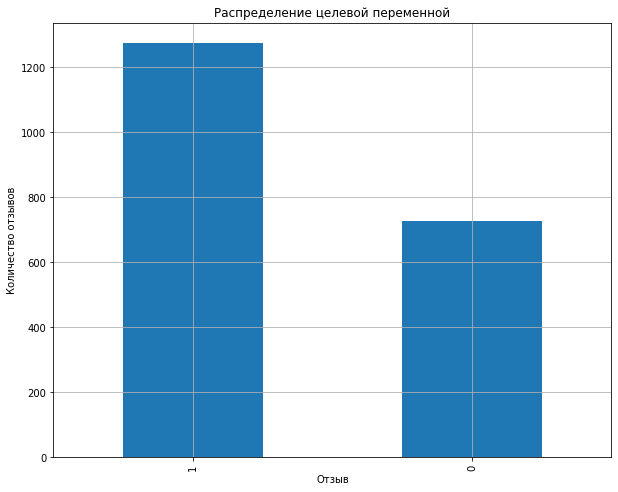

In [36]:
plt.figure(figsize=(10,8))
train['label'].value_counts().plot(kind='bar')
plt.title('Распределение целевой переменной')
plt.xlabel('Отзыв')
plt.ylabel('Количество отзывов')
plt.grid()
plt.show()

In [37]:
part_pos = train.label.sum() / train.shape[0]
print ('Доля позитивных отзывов:', part_pos)
print ('Доля негативных отзывов:', 1 - part_pos)

Доля позитивных отзывов: 0.637
Доля негативных отзывов: 0.363


Вывод: имеется несбалансированность между положительными и отрицательными отзывами. Добавим в отрицательный класс еще 500 отзывов.

In [40]:
train = shuffle(train.append(train.iloc[list(train[train['label'] == 0].index[:500])]), random_state=1)

In [41]:
train['label'].value_counts()

1    1274
0    1226
Name: label, dtype: int64

In [54]:
x = train.text.values
y = train.label.values

## Анализ качества работы нескольких классификаторов

In [239]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

Создадим ряд моделей с использованием различных методов обработки признаков и обучения.

In [240]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=False)

for vectorizer in [CountVectorizer, TfidfVectorizer]:
    for classifier in [LogisticRegression, LinearSVC, SGDClassifier]:
        scores = cross_val_score(make_pipeline(vectorizer(), TfidfTransformer(), classifier(max_iter=2500, random_state=1)),
                                 train.text, train.label, cv=cv).mean()
        print ('Vectorizer: ', vectorizer())
        print ('Classifier: ', classifier())
        print ('CV mean: ', scores)
        print('\n')

Vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
Classifier:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CV mean:  0.8096


Vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_fea

Лучшие результаты с параметрами по умолчанию показали Tfidf + LinearSVC и CountVectorizer + LinearSVC.

## Определение оптимальных параметров

In [83]:
stop_words = nltk.corpus.stopwords.words('english')

In [227]:
parameters_grid_SVC = {
    'classifier__loss' : ['hinge', 'squared_hinge'],    
    'classifier__C' : np.arange(0.1, 2, 0.05),
    'classifier__tol' : [1e-5, 1e-4, 1e-3]
    }
parameters_grid_Tfidf = {
    'vectorizer__max_df': np.arange(0.1, 1.0, 0.005),
    'vectorizer__min_df': np.arange(1, 10, 1),
    'vectorizer__stop_words': (None, stop_words, 'english'),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)],
    }

parameters_grid_logistic = {
    'classifier__penalty' : ['l1', 'l2', 'elasticnet'],    
    'classifier__C' : np.arange(0.1, 2, 0.05),
    'classifier__tol' : [1e-5, 1e-4, 1e-3],
    'classifier__max_iter' : np.arange(100, 3000, 100) 
    }

In [243]:
parameters_grid_count = {
    'vectorizer__max_df': np.arange(0.1, 1.0, 0.005),
    'vectorizer__min_df': np.arange(1, 10, 1),
    'vectorizer__stop_words': (None, stop_words, 'english'),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]
    
}


In [285]:
def make_estimator(vectorizer, classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(vectorizer(), TfidfTransformer(), classifier(max_iter=5000))
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=cv, random_state=1, n_iter=100)
    grid_cv.fit(data, labels)
    return grid_cv

### TfidfVectorizer + LinearSVC

In [286]:
%%time
grid_search_SVC_Tfidf = make_estimator(TfidfVectorizer, LinearSVC, 
                                    {**parameters_grid_Tfidf, **parameters_grid_SVC}, 'accuracy', train.text, train.label)
print ('Tf-idf + LinearSVC')
print ('Best score', grid_search_SVC_Tfidf.best_score_)
print ('Best parametrs', grid_search_SVC_Tfidf.best_params_)

Tf-idf + LinearSVC
Best score 0.7835000000000001
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 7), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.7200000000000005, 'classifier__tol': 0.001, 'classifier__loss': 'hinge', 'classifier__C': 1.9000000000000008}
Wall time: 1min 23s


### CountVectorizer + LinearSVC

In [245]:
%%time
grid_search_SVC_count = make_estimator(CountVectorizer, LinearSVC, 
                                    {**parameters_grid_count, **parameters_grid_SVC}, 'accuracy', train.text, train.label)
print ('CountVectorizer + LinearSVC')
print ('Best score', grid_search_SVC_count.best_score_)
print ('Best parametrs', grid_search_SVC_count.best_params_)

CountVectorizer + LinearSVC
Best score 0.8724000000000001
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 7), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.7200000000000005, 'classifier__tol': 0.001, 'classifier__loss': 'hinge', 'classifier__C': 1.9000000000000008}
Wall time: 1min 30s


### CountVectorizer + LogisticRegression

In [246]:
%%time
pipeline_log = make_pipeline(CountVectorizer(), TfidfTransformer(), LogisticRegression(solver='liblinear'))
grid_cv = RandomizedSearchCV(pipeline_log, {**parameters_grid_count, **parameters_grid_logistic},
                             scoring='accuracy', cv=cv, random_state=1, n_iter=100)
grid_search_log_count = grid_cv.fit(train.text, train.label)

print ('CountVectorizer + LogisticRegression')
print ('Best score', grid_search_log_count.best_score_)
print ('Best parametrs', grid_search_log_count.best_params_)

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

CountVectorizer + LogisticRegression
Best score 0.866
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 6), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.1950000000000001, 'classifier__tol': 1e-05, 'classifier__penalty': 'l2', 'classifier__max_iter': 1600, 'classifier__C': 0.6000000000000002}
Wall time: 1min 39s


После определения оптимальных параметров лучший результат по метрике accuracy наблюдается у Tfidf + LinearSVC

## Предсказания модели


In [260]:
best = make_pipeline(TfidfVectorizer(ngram_range=(1,7), min_df=1, max_df=0.72, stop_words=None),
                   TfidfTransformer(),
                   LinearSVC(tol=0.001, loss='hinge', C=1.9, random_state=1))
best.fit(train.text, train.label)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.72, max_features=None,
                                 min_df=1, ngram_range=(1, 7), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pat...\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('

In [261]:
test_predict = best.predict(test.text)

In [279]:
test['y'] = test_predict
answer = test.drop('text',axis=1)
answer

,y
Id,
0,1
1,0
2,1
3,1
4,1
...,...
495,0
496,1
497,0


In [281]:
answer

,y
Id,
0,1
1,0
2,1
3,1
4,1
...,...
495,0
496,1
497,0


In [282]:
answer.to_csv('answer.csv')